In [92]:
import tensorflow as tf
import numpy as np
import os
import time
import t3f

from TTGP.covariance import SE_multidim
from TTGP.projectors import Identity
from TTGP.io import prepare_data, make_tensor

from TTGP.gpc import TTGPC
from TTGP.gpc_semi import TTGPCSemi
from TTGP import grid
from TTGP.misc import accuracy, num_correct

from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
def _make_batches_xy(x, y, batch_size):
    sample_x, sample_y = tf.train.slice_input_producer([x, y], shuffle=True)
    sample = [sample_x, sample_y]
    x_batch, y_batch = tf.train.batch(sample, batch_size, 
        num_threads=1, capacity=256+3*batch_size)
    return x_batch, y_batch

def _make_batches_x(x, batch_size):
    sample_x = tf.train.slice_input_producer([x], shuffle=True)
    x_batch = tf.train.batch(sample_x, batch_size, 
        num_threads=1, capacity=256+3*batch_size)
    return x_batch

def _make_mu_initializers(y_init, d):
    n_init = y_init.get_shape()[0]
    y_init_cores = [tf.cast(tf.reshape(y_init, (-1, 1, 1, 1, 1)), tf.float64)]
    for core_idx in range(d):
      if core_idx > 0:
        y_init_cores += [tf.ones((n_init, 1, 1, 1, 1), dtype=tf.float64)]
    y_init = t3f.TensorTrainBatch(y_init_cores)
    return y_init

## Supervised, full data

In [94]:
tf.reset_default_graph()

In [95]:
d = 2
C = 3
batch_size = 5
mu_ranks = 5
n_epoch = 10
lr_init = 0.05
n_inputs = 10

decay = (50, 0.1)

projector = Identity(D=d)
covs = SE_multidim(C, 0.7, 0.2, 0.1, projector)

x_tr, y_tr, x_te, y_te = prepare_data('data/', 'numpy', target='class')
x_tr = make_tensor(x_tr, 'x_tr')
y_tr = make_tensor(y_tr.astype(int), 'y_tr', dtype=tf.int64)
x_te = make_tensor(x_te, 'x_te')
y_te = make_tensor(y_te.astype(int), 'y_te', dtype=tf.int64)

Preparing Data


In [96]:
x_batch, y_batch = _make_batches_xy(x_tr, y_tr, batch_size)
x_init, y_init = _make_batches_xy(x_tr, y_tr, mu_ranks)
y_init = _make_mu_initializers(y_init, d)

In [97]:
inputs = grid.InputsGrid(d, npoints=n_inputs, left=-1.)

In [98]:
N = y_tr.get_shape()[0].value 
N_te = y_te.get_shape()[0].value 
iter_per_epoch = int(N / batch_size)

maxiter = iter_per_epoch * n_epoch

In [99]:
gp = TTGPC(covs, inputs, x_init, y_init, mu_ranks) 

In [100]:
global_step = tf.Variable(0, trainable=False)
steps = iter_per_epoch * decay[0]
print(steps, 'steps before decay')
lr = tf.train.exponential_decay(lr_init, global_step, 
                        steps, decay[1], staircase=True)

100 steps before decay


In [101]:
elbo, train_op = gp.fit(x_batch, y_batch, N, lr, global_step)
pred = gp.predict(x_te, test=True)
accuracy_te = accuracy(pred, y_te)

In [102]:
coord = tf.train.Coordinator()
init = tf.global_variables_initializer()
data_initializer = tf.variables_initializer([x_tr, y_tr, x_te, y_te])
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) 

In [103]:
sess = tf.Session()

In [104]:
sess.run(data_initializer)
threads = tf.train.start_queue_runners(sess=sess, coord=coord) 
gp.initialize(sess)
sess.run(init)

In [108]:
batch_elbo = 0
start_epoch = time.time()
# Training
for i in range(maxiter):
    if (not (i % iter_per_epoch)):
        if i == 0:
            print('Epoch', i/iter_per_epoch, ', lr=', sess.run(lr), ':')
        if i != 0:
            print('\tEpoch took:', time.time() - start_epoch)
        accuracy_val = sess.run(accuracy_te)
        print('\taccuracy on test set:', accuracy_val) 
        print('\taverage elbo:', batch_elbo / iter_per_epoch)
        print()

        batch_elbo = 0
        start_epoch = time.time()

    # Training operation
    elbo_val, _, _ = sess.run([elbo, train_op, update_ops])
    batch_elbo += elbo_val

Epoch 0.0 , lr= 0.05 :
	accuracy on test set: 0.993
	average elbo: 0.0

	Epoch took: 0.017679214477539062
	accuracy on test set: 0.993
	average elbo: 22.7443295196

	Epoch took: 0.02129197120666504
	accuracy on test set: 0.992
	average elbo: 22.7479862301

	Epoch took: 0.01668715476989746
	accuracy on test set: 0.992
	average elbo: 22.7444161611

	Epoch took: 0.016253948211669922
	accuracy on test set: 0.992
	average elbo: 22.7365237308

	Epoch took: 0.016555070877075195
	accuracy on test set: 0.992
	average elbo: 22.7372204259

	Epoch took: 0.017753124237060547
	accuracy on test set: 0.992
	average elbo: 22.7315013395

	Epoch took: 0.019994258880615234
	accuracy on test set: 0.992
	average elbo: 22.7279670089

	Epoch took: 0.01987004280090332
	accuracy on test set: 0.993
	average elbo: 22.7278999984

	Epoch took: 0.016376018524169922
	accuracy on test set: 0.993
	average elbo: 22.7260627063



In [109]:
def visualize(gp_model, x_min=None, x_max=None, y_min=None, y_max=None, n_grid=100,
             with_last_class=True):
    
    x_tr_ = sess.run(x_tr)
    y_tr_ = sess.run(y_tr)
    x_te_ = sess.run(x_te)
    y_te_ = sess.run(y_te)
    print(x_te_.shape)
    print(y_te_.shape)
    X = np.vstack([x_tr_, x_te_])
    
    min_ = np.array((np.min(X[:, 0]), np.min(X[:, 1])))
    max_ = np.array((np.max(X[:, 0]), np.max(X[:, 1])))

    if x_max is None: x_max = max_[0]
    if x_min is None: x_min = min_[0]
    if y_max is None: y_max = max_[1]
    if y_min is None: y_min = min_[1]
    
    w_grid_x = np.linspace(x_min, x_max, num=n_grid)
    w_grid_y = np.linspace(y_min, y_max, num=n_grid)
    w_grid_x_, w_grid_y_ = np.meshgrid(w_grid_x, w_grid_y)
    
    w_grid_x_ = w_grid_x_.reshape(-1)[:, None]
    w_grid_y_ = w_grid_y_.reshape(-1)[:, None]
    w_grid = np.hstack([w_grid_x_, w_grid_y_])
    
    w_grid = make_tensor(w_grid, 'w_grid')
    sess.run(tf.variables_initializer([w_grid]))
    classes = sess.run(gp_model.predict(w_grid))
#     if not with_last_class:
#         probs = probs[:, :-1]

    color_lst = ['bo', 'go', 'ro', 'yo', 'mo', 'ko']
    
    plt.figure(figsize=(15, 10))
#     plt.plot(X_u[:, 0], X_u[:, 1], 'kx', alpha=0.9)
    for cl in range(np.max(y_tr_)+1):
        plt.plot(x_tr_[y_tr_ == cl][:, 0], x_tr_[y_tr_ == cl][:, 1], color_lst[cl], alpha=0.9, ms=10)
        plt.plot(x_te_[y_te_ == cl][:, 0], x_te_[y_te_ == cl][:, 1], color_lst[cl], alpha=0.9, ms=3)
        print(cl, ':', np.sum(classes == cl))
    
#     CS = plt.contour(w_grid_x, w_grid_y, val.reshape((n_grid, n_grid)))
#     plt.clabel(CS, inline=1, fontsize=10)
    
    im = plt.imshow(classes.reshape((n_grid, n_grid)), interpolation='bilinear', origin='lower',
            cmap='hot', extent=(x_min, x_max, y_min, y_max))
    
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])

(1000, 2)
(1000,)
0 : 3883
1 : 3588
2 : 2529


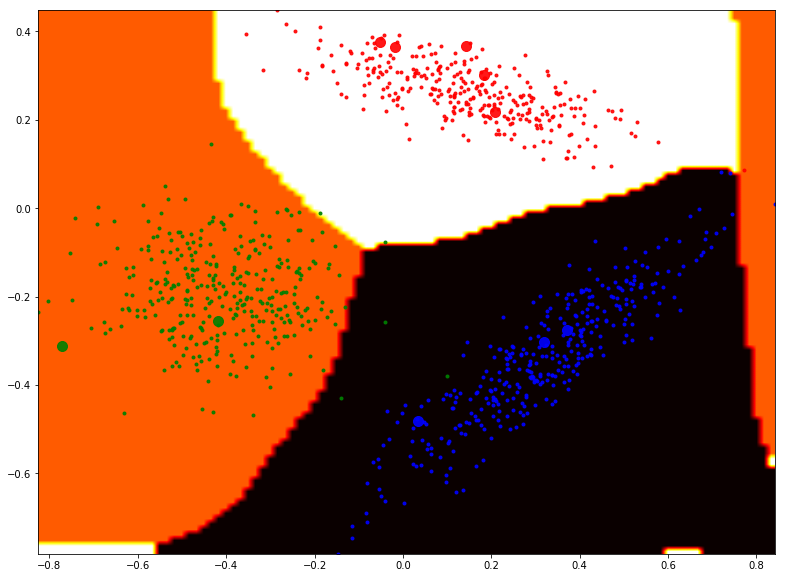

In [110]:
visualize(gp_model=gp)

## Semi-supervised

In [111]:
tf.reset_default_graph()

In [112]:
d = 2
batch_size = 5
mu_ranks = 5
n_epoch = 10
lr_init = 0.05

decay = (50, 0.1)

projector = Identity(D=d)
covs = SE_multidim(C, 0.7, 0.2, 0.1, projector)

x_tr, y_tr, x_u, x_te, y_te = prepare_data('data/', 'numpy', target='class', semi=True)
x_tr = make_tensor(x_tr, 'x_tr')
y_tr = make_tensor(y_tr.astype(int), 'y_tr', dtype=tf.int64)
x_u = make_tensor(x_u, 'x_u')
x_te = make_tensor(x_te, 'x_te')
y_te = make_tensor(y_te.astype(int), 'y_te', dtype=tf.int64)

Preparing Data


In [113]:
x_batch, y_batch = _make_batches_xy(x_tr, y_tr, batch_size)
x_u_batch = _make_batches_x(x_u, batch_size)
x_init, y_init = _make_batches_xy(x_tr, y_tr, mu_ranks)
y_init = _make_mu_initializers(y_init, d)
inputs = grid.InputsGrid(d, npoints=n_inputs, left=-1.)

In [114]:
N = y_tr.get_shape()[0].value 
N_te = y_te.get_shape()[0].value 
iter_per_epoch = int(N / batch_size)

maxiter = iter_per_epoch * n_epoch

global_step = tf.Variable(0, trainable=False)
steps = iter_per_epoch * decay[0]
print(steps, 'steps before decay')
lr = tf.train.exponential_decay(lr_init, global_step, 
                        steps, decay[1], staircase=True)

100 steps before decay


In [115]:
gp = TTGPCSemi(covs, inputs, x_init, y_init, mu_ranks) 
elbo, train_op = gp.fit(x_batch, y_batch, x_u_batch, N, lr, global_step)
pred = gp.predict(x_te, test=True)
accuracy_te = accuracy(pred, y_te)

sample_f/shape Tensor("concat_14:0", shape=(2,), dtype=int32)
sample_f/means, variances <unknown> <unknown>
sample_f/shape Tensor("concat_21:0", shape=(2,), dtype=int32)
sample_f/means, variances <unknown> <unknown>


In [116]:
coord = tf.train.Coordinator()
init = tf.global_variables_initializer()
data_initializer = tf.variables_initializer([x_tr, y_tr, x_u, x_te, y_te])
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) 
sess.close()
sess = tf.Session()
sess.run(data_initializer)
threads = tf.train.start_queue_runners(sess=sess, coord=coord) 
gp.initialize(sess)
sess.run(init)

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: batch/fifo_queue_enqueue = QueueEnqueueV2[Tcomponents=[DT_DOUBLE, DT_INT64], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](batch/fifo_queue, input_producer/Gather, input_producer/Gather_1)]]


In [124]:
batch_elbo = 0
start_epoch = time.time()
# Training
for i in range(maxiter):
    if (not (i % iter_per_epoch)):
        if i == 0:
            print('Epoch', i/iter_per_epoch, ', lr=', sess.run(lr), ':')
        if i != 0:
            print('\tEpoch took:', time.time() - start_epoch)
        accuracy_val = sess.run(accuracy_te)
        print('\taccuracy on test set:', accuracy_val) 
        print('\taverage elbo:', batch_elbo / iter_per_epoch)
        print()

        batch_elbo = 0
        start_epoch = time.time()

    # Training operation
    elbo_val, _, _ = sess.run([elbo, train_op, update_ops])
    batch_elbo += elbo_val

Epoch 0.0 , lr= 0.005 :
	accuracy on test set: 0.99
	average elbo: 0.0

	Epoch took: 0.023873090744018555
	accuracy on test set: 0.991
	average elbo: 23.3344901843

	Epoch took: 0.022909879684448242
	accuracy on test set: 0.992
	average elbo: 22.9918817948

	Epoch took: 0.022876739501953125
	accuracy on test set: 0.992
	average elbo: 23.2220634146

	Epoch took: 0.02244400978088379
	accuracy on test set: 0.992
	average elbo: 23.2793367829

	Epoch took: 0.023624897003173828
	accuracy on test set: 0.992
	average elbo: 22.9141811944

	Epoch took: 0.026865720748901367
	accuracy on test set: 0.992
	average elbo: 23.2308036596

	Epoch took: 0.023860931396484375
	accuracy on test set: 0.992
	average elbo: 23.2264729457

	Epoch took: 0.02284383773803711
	accuracy on test set: 0.992
	average elbo: 23.2451368724

	Epoch took: 0.022809982299804688
	accuracy on test set: 0.992
	average elbo: 22.9136014628



(1000, 2)
(1000,)
0 : 3843
1 : 3141
2 : 3016


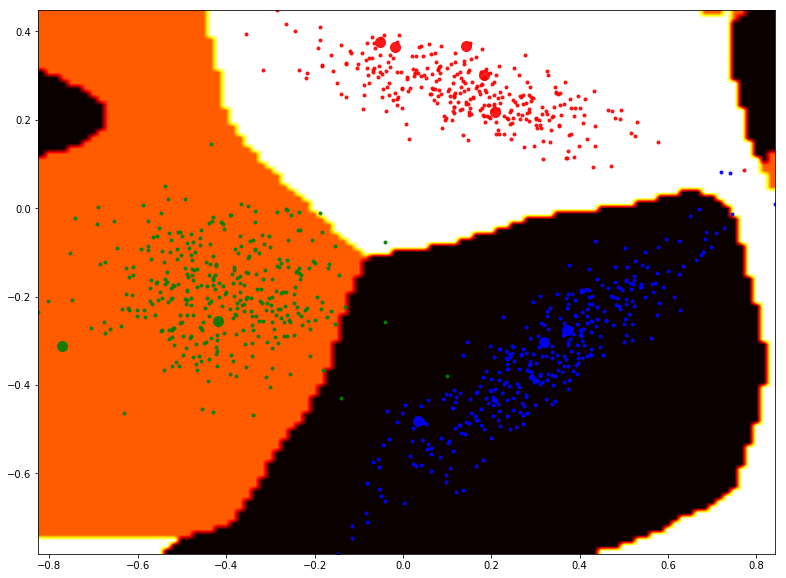

In [125]:
visualize(gp_model=gp)